In [1]:
from src.models.data_augmentation.VAE import *
from src.models.data_augmentation.WAE import *
from src.models.data_augmentation.GAN import *

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from src.utils.evaluation import *

In [3]:
dataset_path = "data/data_combined_controls.csv"

In [4]:
dataset, tensor_data, scaled_data, scaler, original_dim = process(dataset_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
dataset, tensor_data, scaled_data, scaler, original_dim = process(dataset_path)

vae = train_vae(dataset, original_dim)
augmented_df = generate_vae(vae, scaled_data.columns, scaler)

Training VAE: 100%|██████████| 100/100 [00:00<00:00, 120.57it/s]


In [6]:
compare_stats_df = compare_statistics(scaled_data, augmented_df)
compare_distributions_df = compare_distributions(scaled_data, augmented_df)

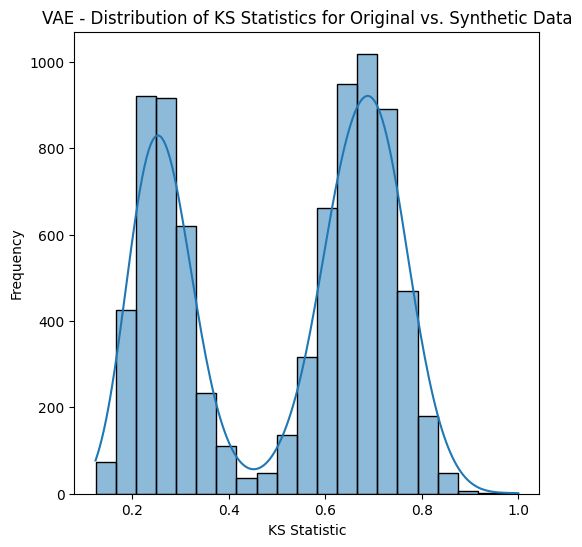

In [7]:
plt.figure(figsize=(6, 6))
sns.histplot(compare_distributions_df['KS Statistic'], kde=True)
plt.title('VAE - Distribution of KS Statistics for Original vs. Synthetic Data')
plt.xlabel('KS Statistic')
plt.ylabel('Frequency')
plt.show()

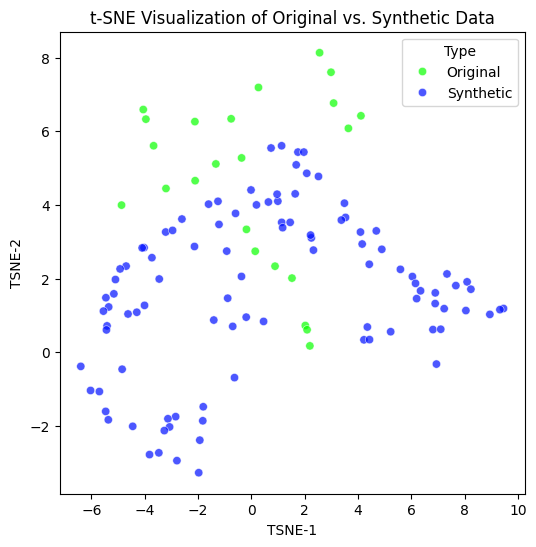

In [8]:
generate_tsne(scaled_data, augmented_df)

# WAE

In [9]:
dataset, tensor_data, scaled_data, scaler, original_dim = process(dataset_path)

wae = train_wae(dataset, original_dim)
augmented_df = generate_wae(wae, scaled_data.columns, scaler)

Training WAE: 100%|██████████| 100/100 [00:00<00:00, 125.60it/s]


In [10]:
compare_stats_df = compare_statistics(scaled_data, augmented_df)
compare_distributions_df = compare_distributions(scaled_data, augmented_df)

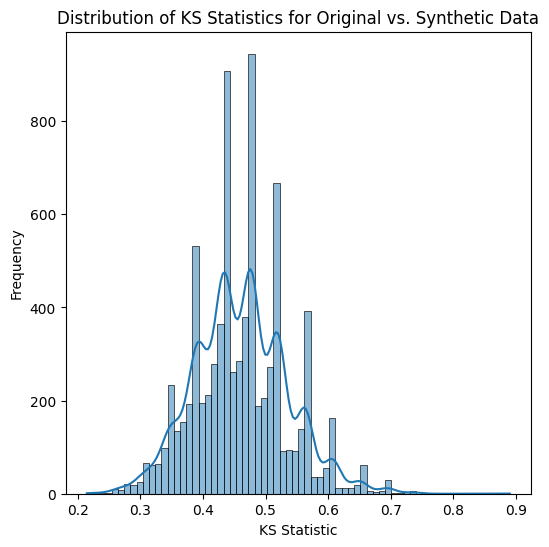

In [11]:
plt.figure(figsize=(6, 6))
sns.histplot(compare_distributions_df['KS Statistic'], kde=True)
plt.title('Distribution of KS Statistics for Original vs. Synthetic Data')
plt.xlabel('KS Statistic')
plt.ylabel('Frequency')
plt.show()

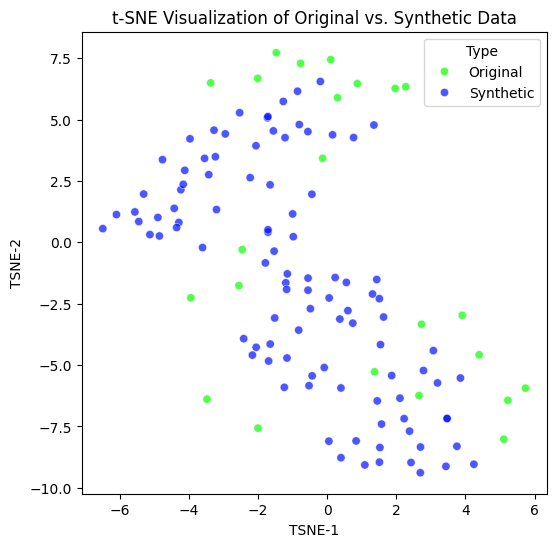

In [12]:
generate_tsne(scaled_data, augmented_df)

# WGAN

Training WGAN-GP:  20%|██        | 1/5 [00:07<00:30,  7.60s/it]

Epoch: 0, Batch: 0, G_loss: 14.813651084899902, C_loss: -175.6124267578125


Training WGAN-GP:  40%|████      | 2/5 [00:15<00:22,  7.65s/it]

Epoch: 1, Batch: 0, G_loss: -49.60042953491211, C_loss: -184.1978302001953


Training WGAN-GP:  60%|██████    | 3/5 [00:22<00:15,  7.63s/it]

Epoch: 2, Batch: 0, G_loss: -29.96347999572754, C_loss: 158.94039916992188


Training WGAN-GP:  80%|████████  | 4/5 [00:30<00:07,  7.62s/it]

Epoch: 3, Batch: 0, G_loss: 20.838916778564453, C_loss: -25.226314544677734


Training WGAN-GP: 100%|██████████| 5/5 [00:38<00:00,  7.62s/it]

Epoch: 4, Batch: 0, G_loss: 65.43826293945312, C_loss: -85.21714782714844


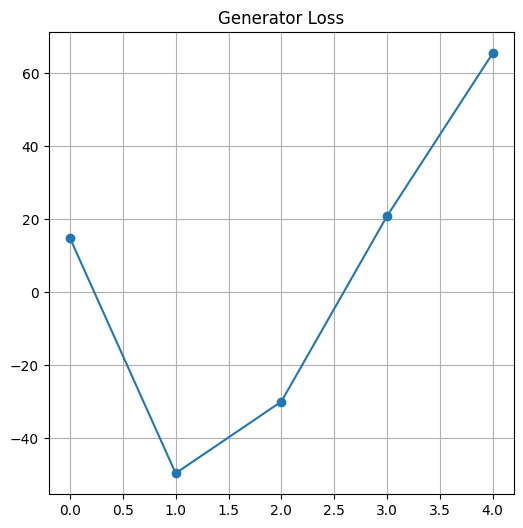

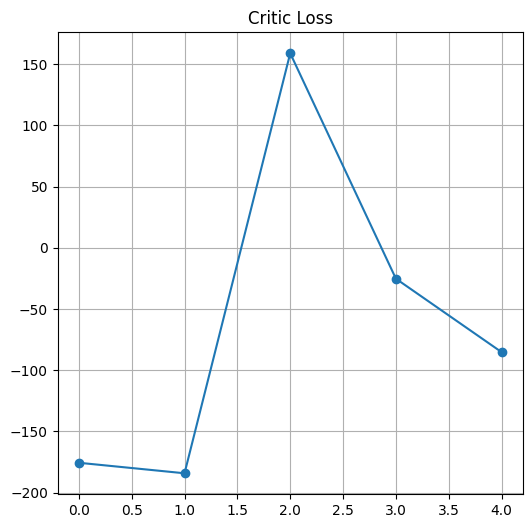

In [13]:
dataset, tensor_data, scaled_data, scaler, original_dim = process(dataset_path)
generated_samples = train_and_generate(dataset_path, batch_size=32, epochs=5)

In [14]:
generated_df = pd.DataFrame(generated_samples, columns=scaled_data.columns)
df_unscaled = pd.DataFrame(scaler.inverse_transform(generated_df), columns=generated_df.columns)
ks_stats = compare_distributions(scaled_data, df_unscaled)

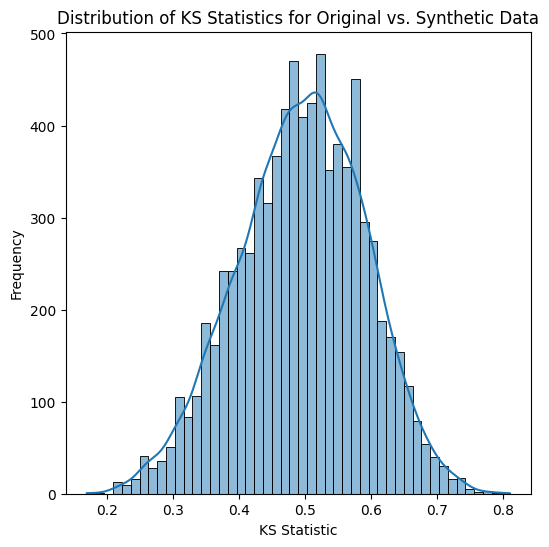

In [15]:
plt.figure(figsize=(6, 6))
sns.histplot(ks_stats['KS Statistic'], kde=True)
plt.title('Distribution of KS Statistics for Original vs. Synthetic Data')
plt.xlabel('KS Statistic')
plt.ylabel('Frequency')
plt.show()

In [21]:
from src.evaluation.metrics import EvaluationMetrics

augmented_data_with_variance = recenter_data(df_unscaled, scaled_data)
ks_stats_with_added_variance = EvaluationMetrics.compute_ks_statistics(scaled_data, augmented_data_with_variance)

TypeError: Could not convert ['OriginalOriginalOriginalOriginalOriginalOriginalOriginalOriginalOriginalOriginalOriginalOriginalOriginalOriginalOriginalOriginalOriginalOriginalOriginalOriginalOriginalOriginalOriginal'] to numeric

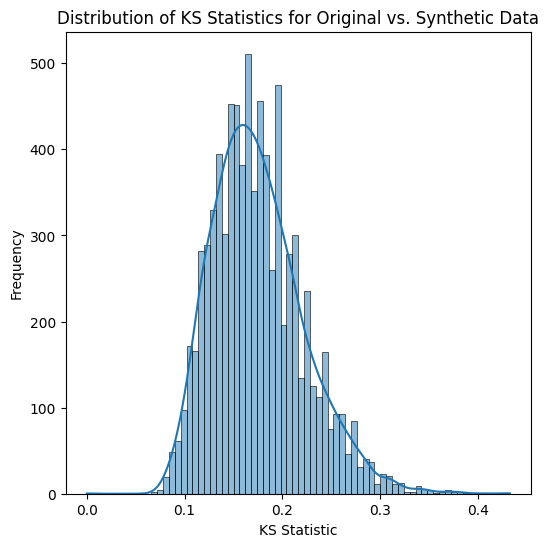

In [17]:
plt.figure(figsize=(6, 6))
sns.histplot(ks_stats_with_added_variance['KS Statistic'], kde=True)
plt.title('Distribution of KS Statistics for Original vs. Synthetic Data')
plt.xlabel('KS Statistic')
plt.ylabel('Frequency')
plt.show()

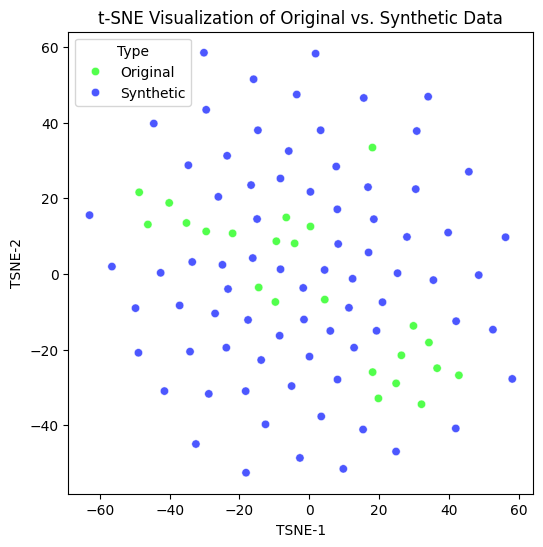

In [18]:
generate_tsne(scaled_data, augmented_data_with_variance)